In [2]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
from mne_icalabel import label_components

import sys
sys.path.append('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils')
from pp_utils import *
from plot_utils import *


In [3]:
def mapchange_keystrokes_3(t_modeswitch, t_keystroke):
    """ 
    Finds all the keystroke triggers that are the first keystrokes after a map change.

    t_modeswitch: subset of events_array with all mode switch triggers 
    t_keystroke: subset of events_array with all keystrokes
    ---
    Returns: first keystrokes, a np array in the same format as events_array (3 columns, first column is time)
    """
    
    first_keystrokes = []
    switch_times = t_modeswitch[:, 0]  # Extract mode switch times
    switch_idx = 0
    n_switches = len(switch_times)

    

    keystroke_times = t_keystroke[:,0]

    for keystroke in t_keystroke:
        if switch_idx >= n_switches - 2:
            break

        ktime = keystroke[0]

        #make sure the keystroke is between two mode switches
        if ktime> switch_times[switch_idx] and ktime < switch_times[switch_idx+1]:
            first_keystrokes.append(keystroke)
            switch_idx+=1
        
        #if there are no keystrokes between two mode switches, this forces it to jump to the next mode
        elif ktime > switch_times[switch_idx+1] and ktime < switch_times[switch_idx+2]:
            first_keystrokes.append(keystroke)
            switch_idx+=2

    return np.array(first_keystrokes)


In [4]:

#======================================================================================
#                        PARAMETERS
#======================================================================================

#CHANGE THIS AS THE EXPERIMENT PROGRESSES
#----------------------------------------
#subjects_to_process =  ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
subjects_to_process = ['08']
periods = ['post']
keystroke_trigs = 'audio'

overwrite = True #overwrite existing files
plot = False

find_mapchanges = True
find_modekeystrokes = True

#-----------------------------------------

#times for cropping ERPs
erp_begin = -0.5
erp_end = 0.5


#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed_30Hz" #where the preprocessed files are
evokeds_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_ERP_data_n05to05_30Hz'
epochs_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz'

for folder in [evokeds_folder, epochs_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)
#======================================================================================
#                        CALCULATE EVOKEDS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue

    print('\nPROCESSING SUBJECT ', folder)
    sub_pp_dir = os.path.join(pp_dir, folder)
    for period in periods:
        data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_error_{period}_??.mat'))[0]

        subject_ID = data_path.split('.')[0][-2:]

        print('Opening', data_path.split('/')[-1])
        

        #--------------------------------------------
        #               LOAD FILE AND EVENTS
        #--------------------------------------------
        data = loadmat(data_path)
        eeg = data['trial_data']
        refs = data['trial_mastoids']
        all_electrodes = data['all_electrodes']
        events_sv = data['events']

        if plot:
            mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)  

        events_arr = make_raw_events(events_sv)

        if keystroke_trigs == 'MIDI':
            t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==6])
        else:
            t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])


        t_inv = clean_triggers(events_arr[events_arr[:, 2]==3])
        t_shinv = clean_triggers(events_arr[events_arr[:, 2]==4])
        t_norm = clean_triggers(events_arr[events_arr[:, 2]==5])
        t_modeswitch = np.concatenate([t_inv, t_shinv, t_norm])
        t_modeswitch = events_inorder(t_modeswitch)
        first_keystrokes = mapchange_keystrokes_3(t_modeswitch = t_modeswitch, t_keystroke=t_keystrokes)
        other_keystrokes = withinmap_keystrokes(t_keystrokes, first_keystrokes)


        



PROCESSING SUBJECT  08
Opening eeg_error_post_08.mat


(0.0, 10000.0)

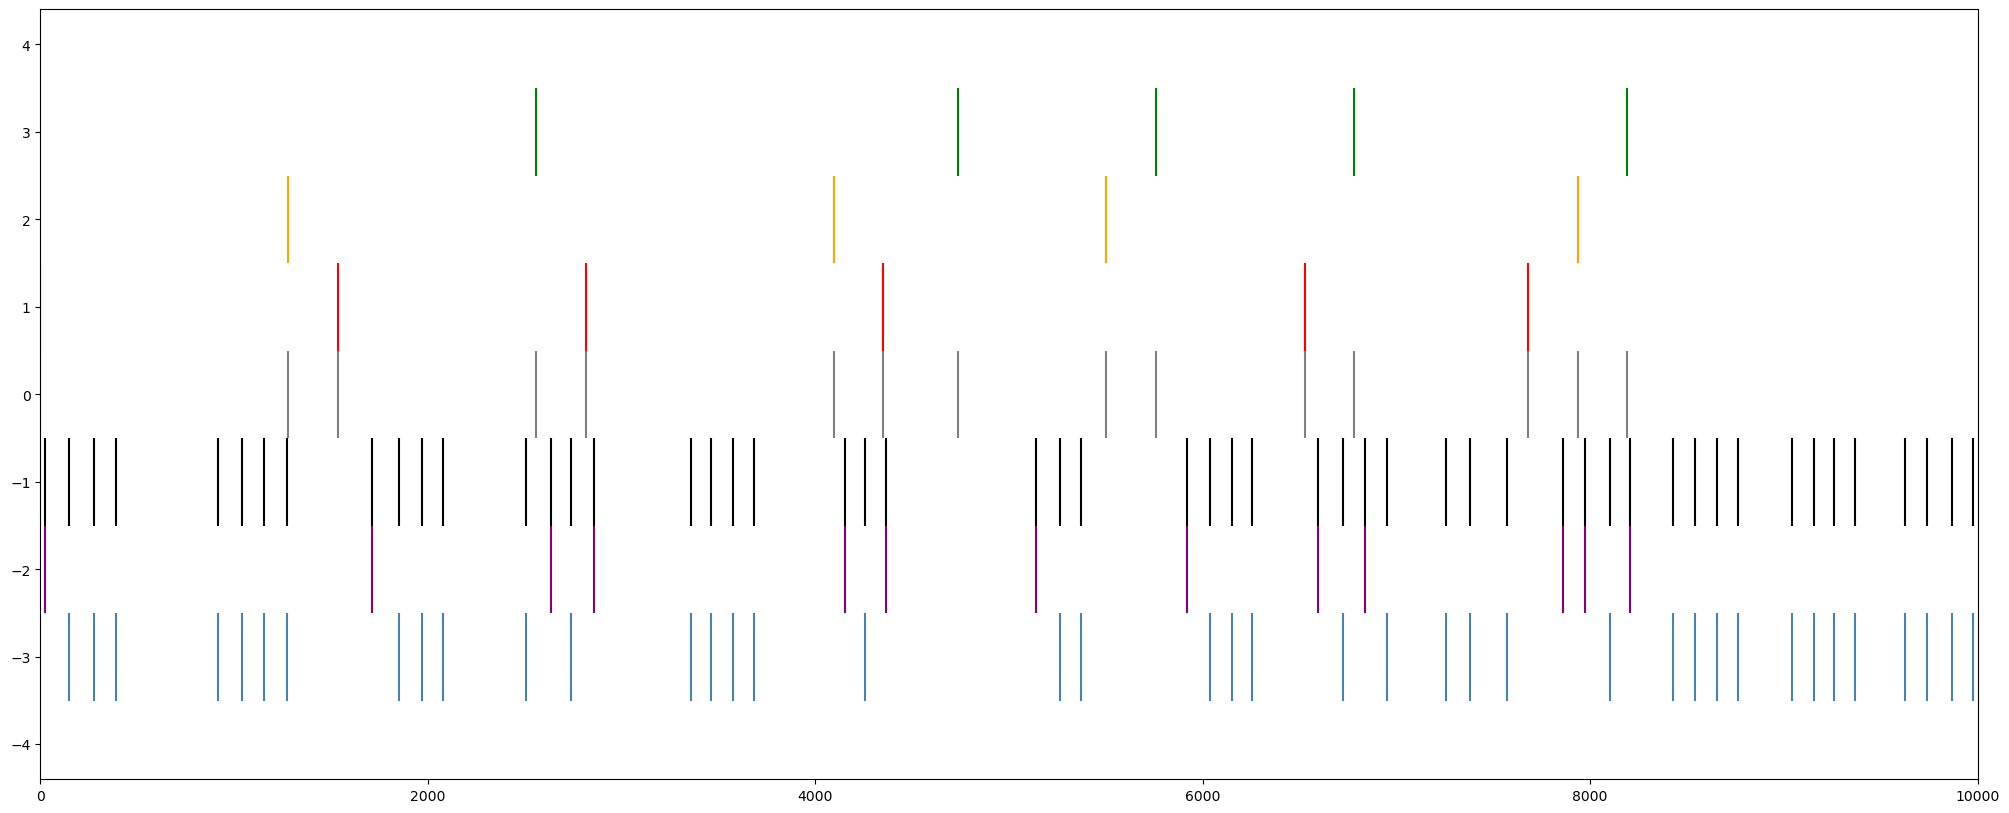

In [5]:
plt.figure(figsize = (25,10))
plt.eventplot(t_inv[:, 0], lineoffsets = 3, color = 'green')
plt.eventplot(t_shinv[:,0], lineoffsets = 2, color = 'orange')
plt.eventplot(t_norm[:,0], lineoffsets = 1,color = 'red')
plt.eventplot(t_modeswitch[:,0], lineoffsets = 0, color = 'grey')
plt.eventplot(t_keystrokes[:,0], lineoffsets = -1, color = 'black')
plt.eventplot(first_keystrokes[:,0], lineoffsets = -2, color = 'purple')
plt.eventplot(other_keystrokes[:,0], lineoffsets = -3, color = 'steelblue')
plt.xlim(0,10000)

In [6]:
def create_mapchange_df(first_keystrokes,  all_keystrokes):
    """ 
    Makes a df with the times and indices for first and other keystrokes
        for first keystrokes, further adds the number of keystrokes in the previous map
    returns: mapchange_df
    """

    mapchange_df = pd.DataFrame(columns = ['keystroke_idx', 'time', 'type', 'prev_keystrokes'])
    mapchange_df['time'] = all_keystrokes[:,0]

    mapchange_df['keystroke_idx'] = mapchange_df.index
    mapchange_df['type'] = mapchange_df['time'].apply(
            lambda x: 'first' if x in first_keystrokes[:, 0] 
            else 'other'
    )

    # Find the indices of rows where type is 'first'
    first_indices = mapchange_df.index[mapchange_df['type'] == 'first'].tolist()

    # Iterate over these indices and count 'other' keystrokes
    for i in range(len(first_indices)):
        current_index = first_indices[i]
        if i == 0:
            mapchange_df.at[current_index, 'prev_keystrokes'] = current_index
            #mapchange_df.at[current_index, 'prev_keystrokes'] = 0 #put 0 for previous keystrokes for the first map change (don't use)

        else:
            previous_index = first_indices[i - 1]
            # Count 'other' keystrokes between the two 'first' rows
            count_others = mapchange_df.loc[previous_index+1:current_index-1, 'type'].value_counts().get('other', 0)
            mapchange_df.at[current_index, 'prev_keystrokes'] = count_others

    return mapchange_df

In [7]:
test_mapchange = create_mapchange_df(first_keystrokes, t_keystrokes)
test_mapchange


,keystroke_idx,time,type,prev_keystrokes
0,0,24,first,0
1,1,147,other,NaN
2,2,275,other,NaN
3,3,390,other,NaN
4,4,918,other,NaN
...,...,...,...,...
321,321,74951,other,NaN
322,322,76090,other,NaN
323,323,76207,other,NaN
324,324,76322,other,NaN


In [8]:
test_mapchange.to_csv('test_mapchange_2.csv')

In [9]:
ep = mne.read_epochs('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz_corrected/error_epochs_firsts_post_08.fif').get_data()

Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz_corrected/error_epochs_firsts_post_08.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_66602/1513470999.py:1: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz_corrected/error_epochs_firsts_post_08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep = mne.read_epochs('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz_corrected/error_epochs_firsts_post_08.fif').get_data()


In [10]:
ep_orig = mne.read_epochs('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz/error_epochs_firsts_post_08.fif').get_data()


Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz/error_epochs_firsts_post_08.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_66602/3729620947.py:1: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz/error_epochs_firsts_post_08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_orig = mne.read_epochs('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz/error_epochs_firsts_post_08.fif').get_data()
